In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function

In [3]:
datafile = 'ex3data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']
X = np.insert(X, 0, 1, axis=1)
print "'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y']))
print "'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape)
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [4]:
print X.shape

(5000, 401)


In [5]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        print indices_to_display
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

[4028, 2500, 1598, 3438, 1199, 2173, 353, 4246, 2156, 1924, 3842, 2165, 4848, 140, 3436, 4585, 3347, 3038, 13, 1071, 416, 1681, 2757, 1669, 1846, 987, 4151, 3760, 3232, 2783, 3387, 3331, 658, 4666, 4125, 4880, 949, 3335, 2186, 4680, 2430, 3856, 4013, 87, 3673, 3255, 3381, 2144, 1711, 1748, 639, 1253, 3295, 504, 3445, 2597, 4559, 5, 4484, 4086, 3596, 82, 3467, 2715, 4868, 916, 89, 1063, 3791, 1475, 3605, 383, 2086, 2866, 1871, 4104, 1965, 415, 114, 1934, 1809, 1485, 4398, 2493, 2439, 703, 354, 2111, 1261, 2652, 4885, 1614, 1127, 2471, 2411, 656, 4521, 756, 4831, 707]


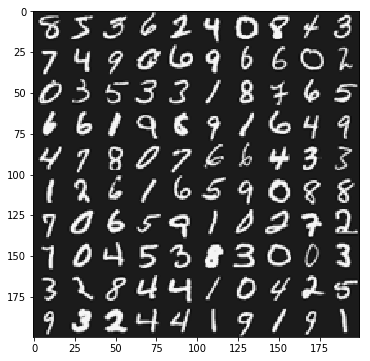

In [6]:
displayData()

In [7]:
print X.shape
s = random.sample(range(X.shape[0]), 100)
len(s)

(5000, 401)


100

In [8]:
#### Vectorizing Logistic Regression ####

In [9]:
#Hypothesis function and cost function for logistic regression
def h(mytheta,myX): #Logistic hypothesis function
    return expit(np.dot(myX,mytheta))

#A more simply written cost function than last week, inspired by subokita:
def computeCost(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0] #5000
    myh = h(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    left_hand = (term1 - term2) / m #shape: (5000,5000)
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m) #shape: (1,1)
    return left_hand + right_hand #shape: (5000,5000)

In [10]:
initial_theta = np.zeros((X.shape[1],1))
h(initial_theta, X).shape
beta = h(initial_theta,X)-y.T
print beta.shape

(5000, 5000)


In [11]:
### One vs All classification ###

In [12]:
#An alternative to OCTAVE's 'fmincg' we'll use some scipy.optimize function, "fmin_cg"
#This is more efficient with large number of parameters.
#In the previous homework, I didn't have to compute the cost gradient because
#the scipy.optimize function did it for me with some kind of interpolation...
#However, fmin_cg needs the gradient handed do it, so I'll implement that here
def costGradient(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0]
    #Tranpose y here because it makes the units work out in dot products later
    #(with the way I've written them, anyway)
    beta = h(mytheta,myX)-myy.T #shape: (5000,5000)

    #regularization skips the first element in theta
    regterm = mytheta[1:]*(mylambda/m) #shape: (400,1)

    grad = (1./m)*np.dot(myX.T,beta) #shape: (401, 5000)
    #regularization skips the first element in theta
    grad[1:] = grad[1:] + regterm
    return grad #shape: (401, 5000)

In [13]:
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [14]:
#Note: I spent a LONG time trying to optimize everything. Initially training 10 classes
#took about 5 minutes. Now I've got it down to taking ~5 seconds total!
def buildTheta():
    """
    Function that determines an optimized theta for each class
    and returns a Theta function where each row corresponds
    to the learned logistic regression params for one class
    """
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    Theta = np.zeros((10,X.shape[1]))
    for i in xrange(10):
        iclass = i if i else 10 #class "10" corresponds to handwritten zero
        print "Optimizing for handwritten number %d..."%i
        logic_Y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
        # print logic_Y
        itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,mylambda)
        Theta[i,:] = itheta
        print Theta
    print "Done!"
    return Theta

In [15]:
Theta = buildTheta()

Optimizing for handwritten number 0...
[[ -8.01735322e+00   0.00000000e+00   0.00000000e+00 ...,  -4.57569290e-04
    2.23265264e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
Optimizing for handwritten number 1...
[[ -8.01735322e+00   0.00000000e+00   0.00000000e+00 ...,  -4.57569290e-04
    2.23265264e-05   0.00000000e+00]
 [ -3.05721131e+00   0.00000000e+00   0.00000000e+00 ...,   4.58367486e-03
    2.59650335e-07   0.00000000e+00]
 [  0.00000000e+00

In [16]:
# print y

In [17]:
x = np.array([[1],[2],[3]])
print x
print x.reshape(-1)

[[1]
 [2]
 [3]]
[1 2 3]


In [18]:
s = np.array([[1],[2],[3]]).T
print s.shape

(1, 3)


In [19]:
# print x - s

In [20]:
# Theta.shape

In [21]:
# for i in xrange(10):
#     iclass = i if i else 10
#     print iclass

In [22]:
def predictOneVsAll(myTheta,myrow):
    """
    Function that computes a hypothesis for an individual image (row in X)
    and returns the predicted integer corresponding to the handwritten image
    """
    classes = [10] + range(1,10)
    hypots  = [0]*len(classes)
    #Compute a hypothesis for each possible outcome
    #Choose the maximum hypothesis to find result
    for i in xrange(len(classes)):
        hypots[i] = h(myTheta[i],myrow)
    return classes[np.argmax(np.array(hypots))] #finds the max H and finds the class

In [23]:
# "You should see that the training set accuracy is about 94.9%"
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in xrange(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print "Training set accuracy: %0.1f%%"%(100*(n_correct/n_total))

Training set accuracy: 89.2%


In [24]:
x = np.array([1,2,3,4,5])
np.argmax(x)

4

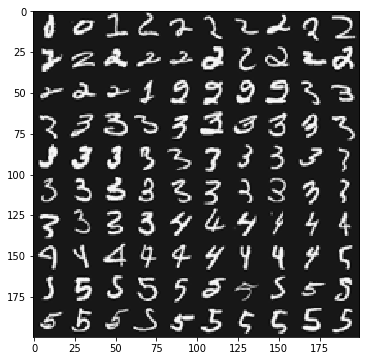

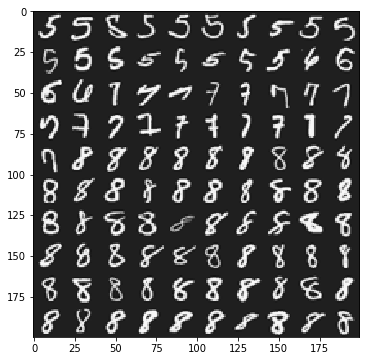

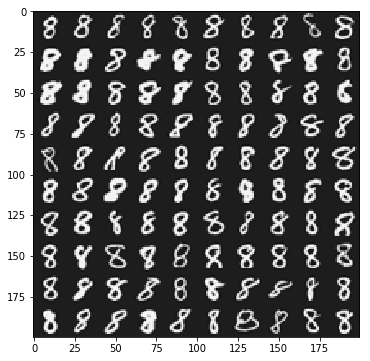

In [25]:
#Let's have a look at the ones we get wrong:
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

In [26]:
### Neural Networks ###

In [27]:
datafile = 'ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print "Theta1 has shape:",Theta1.shape
print "Theta2 has shape:",Theta2.shape
print len(Theta1)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)
25


In [31]:
def propogateForward(row,Thetas):
    features = row
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1)
        print a.shape
        features = a
        
def predictNN(row, Thetas):
    classes = range(1,10) + [10]
    output = propogateForward(row, Thetas)
    return classes[np.argmax(np.array(output))]

In [32]:

# "You should see that the accuracy is about 97.5%"
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []
#Loop over all of the rows in X (all of the handwritten images)
#and predict what digit is written. Check if it's correct, and
#compute an efficiency.
for irow in xrange(X.shape[0]):
    n_total += 1
    if predictNN(X[irow],myThetas) == int(y[irow]): 
        n_correct += 1
    else: incorrect_indices.append(irow)
print "Training set accuracy: %0.1f%%"%(100*(n_correct/n_total))

(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,)
(26,

(26,)
(26,)
(26,)
(26,)
(26,)


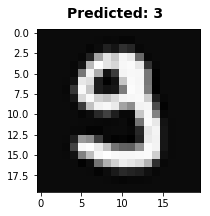

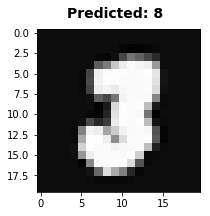

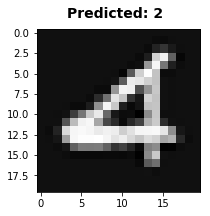

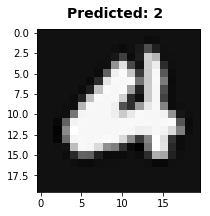

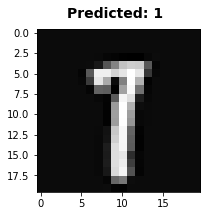

In [33]:
for x in xrange(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = scipy.misc.toimage( getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')